## Model Results

Here, we investigate the results of the model in two different runs with and without the feedback of meltwater into the system.

Begin by importing some necessary modules:

In [131]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Model Results Without Meltwater

First, we will take a look at the model results with meltwater turned off. Note that the iceberg will still melt throughout the model run, but it will not induce changes in the temperature, salinity, and momentum fields of the model.

For reading and plotting purposes, define the parameters the model grid and the iceberg model implementation:

In [132]:
# model grid parameters
n_rows = 11
n_cols = 11
n_depth_levels = 50
max_number_of_icebergs = 30
model_timestep = 60

# vertical cell dimensions defined in the data file
delR = np.array([   1.00,    1.14,    1.30,    1.49,   1.70,
                    1.93,    2.20,    2.50,    2.84,   3.21,
                    3.63,    4.10,    4.61,    5.18,   5.79,
                    6.47,    7.20,    7.98,    8.83,   9.73,
                   10.69,   11.70,   12.76,   13.87,  15.03,
                   16.22,   17.45,   18.70,   19.97,  21.27,
                   22.56,   23.87,   25.17,   26.46,  27.74,
                   29.00,   30.24,   31.45,   32.65,  33.82,
                   34.97,   36.09,   37.20,   38.29,  39.37,
                   40.45,   41.53,   42.62,   43.73,  44.87])

Next, define the location of the run directory:

In [133]:
run_dir = '../../../../example_configs/single_stationary_berg/run'

Now read in the iceberg files generated during the model run. Note that the model was run for 270 days in this model run (different than the default timesteps provided with the model file examples on Github):

In [129]:
# make lists to hold the dimensions
timesteps = []
widths = []
lengths = []
thicknesses = []
freeboards = []

# read in the dimensions one by one
for file_name in sorted(os.listdir(os.path.join(run_dir,'diags','iceberg'))):
    if file_name.startswith('iceberg'):
        output_grid = np.fromfile(os.path.join(run_dir,'diags','iceberg',file_name),'>f8')
        output_grid = output_grid.reshape((15, max_number_of_icebergs)).T
        timesteps.append(int(file_name.split('.')[-2]))
        widths.append(output_grid[0,4])
        lengths.append(output_grid[0,5])
        thicknesses.append(output_grid[0,6])
        freeboards.append(output_grid[0,7])

# convert time to days
time = np.array(timesteps)*model_timestep/86400

Plot the iceberg dimensions through time:

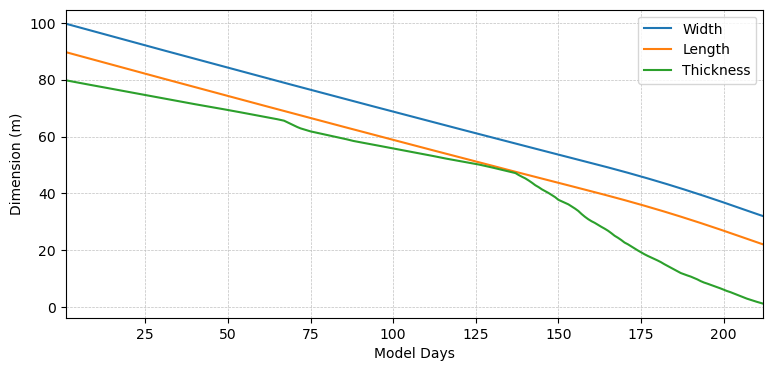

In [137]:
plt.figure(figsize=(9,4))
plt.plot(time, widths, label='Width')
plt.plot(time, lengths, label='Length')
plt.plot(time, thicknesses, label='Thickness')
plt.xlim([np.min(time), np.max(time)])
plt.legend()
plt.xlabel('Model Days')
plt.ylabel('Dimension (m)')
plt.grid(linestyle='--', linewidth=0.5, color='silver')
plt.show()

As we can see, the iceberg steadily melts throughout the model run. When we get to the summer time, the vertical melt rate increases due to enhanced atmospheric, solar, and wave erosion melting. We can observe the breakdown in the melt rate components from the output of the model. First, read in the different melt components:

In [138]:
# make empty array for each melt time
melt_atm = np.zeros((max_number_of_icebergs, np.size(time)))
melt_solar = np.zeros((max_number_of_icebergs, np.size(time)))
melt_wave = np.zeros((max_number_of_icebergs, np.size(time)))
melt_submarine = np.zeros((max_number_of_icebergs, np.size(time), n_depth_levels))

# read in the dimensions one by one
for t,timestep in enumerate(timesteps):
    
    # read in the melt rate due to atmospheric convection
    file_name = 'IBMATMCV.'+'{:010d}'.format(timestep)+'.bin'
    output_grid = np.fromfile(os.path.join(run_dir,'diags','IBMATMCV',file_name),'>f8')
    output_grid = output_grid.reshape((1, max_number_of_icebergs)).T
    melt_atm[:,t] = output_grid[0,:]

    # read in the melt rate due to solar radiation
    file_name = 'IBMSOLAR.'+'{:010d}'.format(timestep)+'.bin'
    output_grid = np.fromfile(os.path.join(run_dir,'diags','IBMSOLAR',file_name),'>f8')
    output_grid = output_grid.reshape((1, max_number_of_icebergs)).T
    melt_solar[:,t] = output_grid[0,:]

    # read in the melt rate due to wave erosion
    file_name = 'IBMWVESN.'+'{:010d}'.format(timestep)+'.bin'
    output_grid = np.fromfile(os.path.join(run_dir,'diags','IBMWVESN',file_name),'>f8')
    output_grid = output_grid.reshape((1, max_number_of_icebergs)).T
    melt_wave[:,t] = output_grid[0,:]

    # read in the melt rate due to submarine melt
    file_name = 'IBMSUBPF.'+'{:010d}'.format(timestep)+'.bin'
    output_grid = np.fromfile(os.path.join(run_dir,'diags','IBMSUBPF',file_name),'>f8')
    output_grid = output_grid.reshape((n_depth_levels, max_number_of_icebergs)).T
    melt_submarine[:,t,:] = output_grid

Next, plot the melt components on a single plot for comparison. Note that submarine melt is depth-resolved, so this plot is shown with a colormap:

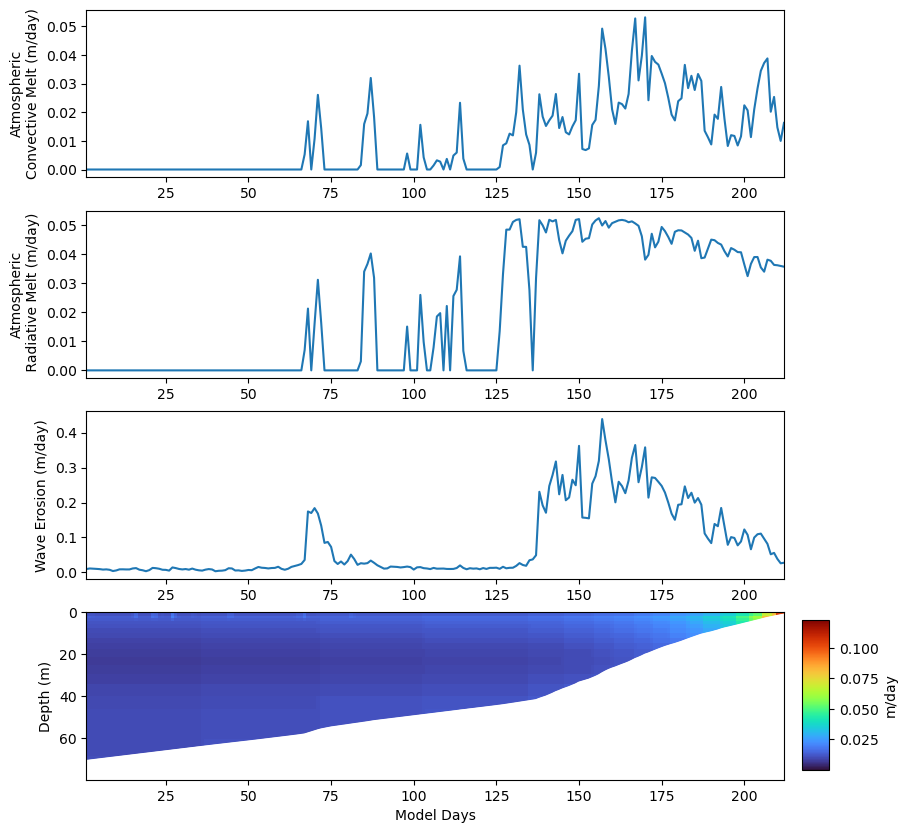

In [140]:
iceberg_number = 0

fig = plt.figure(figsize=(9,10))

plt.subplot(4,1,1)
plt.plot(time, 86400*melt_atm[iceberg_number,:])
plt.ylabel('Atmospheric\nConvective Melt (m/day)')
plt.xlim([np.min(time), np.max(time)])

plt.subplot(4,1,2)
plt.plot(time, 86400*melt_solar[iceberg_number,:])
plt.ylabel('Atmospheric\n Radiative Melt (m/day)')
plt.xlim([np.min(time), np.max(time)])

plt.subplot(4,1,3)
plt.plot(time, 86400*melt_wave[iceberg_number,:])
plt.ylabel('Wave Erosion (m/day)')
plt.xlim([np.min(time), np.max(time)])

plt.subplot(4,1,4)
melt_array = 86400*melt_submarine[iceberg_number,:,:].T
C = plt.pcolormesh(time, np.cumsum(delR),melt_array,
                   shading='auto', cmap='turbo', vmin=np.min(melt_array[melt_array!=0]))
plt.plot(time, freeboards, 'w-')
plt.ylim([np.max(thicknesses),0])
plt.xlim([np.min(time), np.max(time)])
plt.xlabel('Model Days')
plt.ylabel('Depth (m)')

# make a freeboard mask
plt.fill_between(time, freeboards, np.ones_like(time)*np.max(np.cumsum(delR)), color='white')

# add a colorbar
cbar_ax_bbox = [0.92, 0.12, 0.03, 0.15] 
cbar_ax = fig.add_axes(cbar_ax_bbox)
fig.colorbar(C, cax=cbar_ax, label='m/day')


plt.show()